In [1]:
# standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
# statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
# os
import os
# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# tf
import tensorflow as tf
# keras
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Layer, LSTM, GRU, SimpleRNN, Dense, Activation, Bidirectional
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras import optimizers
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.regularizers import l1,l2

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Import btc
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Make pd df
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/NN - 434/btc.csv')

In [4]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Drop extraneous columns
df.drop(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)'], axis = 1, inplace = True)
# Drop bottom 3m rows and top 800k
df.drop(df.index[:3000000], axis = 0, inplace = True)
df.drop(df.index[4000000:], axis = 0, inplace = True)
# Reset index; drop column
df.reset_index(drop = True, inplace = True)
# Backfill na's
df.fillna(method = 'backfill', inplace = True)

In [6]:
# RNN target/features
features = ['Weighted_Price']
target = 'Weighted_Price'

In [7]:
# Augmented Dickey-Fuller will determine stationarity, with a null hypothesis tha there is a unit root 
# (constant bias, no time trend). If p-value > (1-a), then we cannot reject the hypothesis. This suggests that
# the time-series is non-stationary

adf, p, ulag, nobs, cvs, aic = sm.tsa.stattools.adfuller(df[features[0]][:200000].values)

print('adf: ' + str(adf))
print('p: ' + str(p))
print('nobs: ' + str(nobs))
print('cvs: ' + str(cvs))


adf: -1.508414645418148
p: 0.5293447032788678
nobs: 199918
cvs: {'1%': -3.4303827103310676, '5%': -2.8615544575334875, '10%': -2.566777695225296}


In [8]:

# Calculate partial auto-correlation
pacf = sm.tsa.stattools.pacf(df[features], nlags = 30)
# Determine number of steps 
n_steps = np.where(np.array(np.abs(pacf) > 2.58 / np.sqrt(len(df[features]) ) ) == False)[0][0] -1
print('n_steps: ' + str(n_steps) )


n_steps: 3


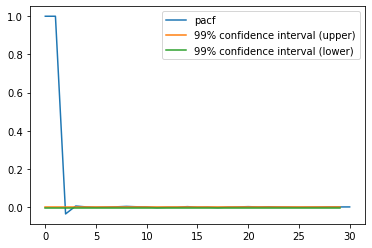

In [9]:

# Plot partial auto-correlation
plt.plot(pacf, label = 'pacf')
plt.plot([2.58/np.sqrt(len(df[features]) ) ] * 30, label = '99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(len(df[features]) ) ] * 30, label = '99% confidence interval (lower)')
plt.legend()


In [10]:
# Split train sets
train_weight = 0.8
df_split = int( len(df) * train_weight )

train = df.iloc[:df_split]
test = df.iloc[df_split:]

In [11]:
# Scaling parameters
mu = float( train[features].mean() )
sigma = float( train[features].std() )

# Scale data
train = train[features].apply( lambda x: (x - mu) / sigma )
test = test[features].apply( lambda x: (x - mu) / sigma )

In [12]:
'''
Function for reshaping data into one-step ahead time series prediction format
    value: feature value to be lagged
    n_steps: number of steps/sequence length
    n_steps_ahead: forecasting horizon
'''

def get_lagged_features(value, n_steps, n_steps_ahead):
    lag_list = []
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append( value.shift(lag) )
    return pd.concat(lag_list, axis = 1)

In [13]:
# Number of steps ahead
n_steps_ahead = n_steps

# Transform training input and output data
col_ords = []
for i in range(n_steps):
    for j in range(len(features)):
        col_ords.append(i + j * n_steps)

x_train_list = []
for f in features:
    x_train_reg = get_lagged_features(train, n_steps, n_steps).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis = 1)
        
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape( x_train_reg.values, ( x_train_reg.shape[0], int( x_train_reg.shape[1] / len(features)), len(features) ) )
y_train_reg = np.reshape( y_train_reg, (y_train_reg.shape[0], 1, 1))

In [14]:
# Transform test input and output data
x_test_list = []
for f in features:
    x_test_reg = get_lagged_features(test, n_steps, n_steps).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis = 1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape( x_test_reg.values, ( x_test_reg.shape[0], int( x_test_reg.shape[1] / len(features)), len(features) ) )
y_test_reg = np.reshape( y_test_reg, (y_test_reg.shape[0], 1, 1))

In [15]:
# Verify tensor shapes
#   value 1: # of observations
#   value 2: sequence length, or number of lags
#   value 3: dimension of each element in the sequence (x) or output vector (y): this is univariate time analysis, so the dimension of I/O is 1

print(x_train_reg.shape)
print(y_train_reg.shape)
print(x_test_reg.shape)
print(y_test_reg.shape)

(1485896, 3, 1)
(1485896, 1, 1)
(371471, 3, 1)
(371471, 1, 1)


In [16]:
# Append lagged lists to train data
x_train_reg = pd.concat(x_train_list, axis = 1)
# Reshape
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape( x_train_reg.values, ( x_train_reg.shape[0], int(x_train_reg.shape[1] / len(features)), len(features) ) )

In [17]:
# Append lagged lists to test data
x_test_reg = pd.concat(x_test_list, axis = 1)
# Reshape
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape( x_test_reg.values, ( x_test_reg.shape[0], int(x_test_reg.shape[1] / len(features)), len(features) ) )

In [18]:
# Custom activation function
def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish)})

In [19]:
# NN structures - tanh

def _RNN(n_units = 10, l1_reg = 0, seed = 0, optim = 'adam'):
    model = Sequential()
    model.add( 
        SimpleRNN(n_units,
                  activation = 'tanh', 
                  kernel_initializer = keras.initializers.glorot_uniform(seed), 
                  bias_initializer = keras.initializers.glorot_uniform(seed), 
                  recurrent_initializer = keras.initializers.orthogonal(seed), 
                  kernel_regularizer = l1(l1_reg), 
                  input_shape = (x_train_reg.shape[1], x_train_reg.shape[-1]),
                  unroll = True,
                  stateful = False) )  
    model.add(
        Dense(1, 
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg) ) )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

def _LSTM(n_units = 10, l1_reg = 0, seed = 0, optim = 'adam'):
    model = Sequential()
    model.add(
        LSTM(n_units,
             activation = 'tanh',
             kernel_initializer = keras.initializers.glorot_uniform(seed), 
             bias_initializer = keras.initializers.glorot_uniform(seed), 
             recurrent_initializer = keras.initializers.orthogonal(seed), 
             kernel_regularizer = l1(l1_reg), 
             input_shape = (x_train_reg.shape[1], x_train_reg.shape[-1]),
             unroll = True,
             stateful = False) )
    model.add(
        Dense(1,
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg) ) )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

def _GRU(n_units = 10, l1_reg = 0, seed = 0, optim = 'adam'):
    model = Sequential()
    model.add(
        GRU(n_units,
             activation = 'tanh',
             kernel_initializer = keras.initializers.glorot_uniform(seed), 
             bias_initializer = keras.initializers.glorot_uniform(seed), 
             recurrent_initializer = keras.initializers.orthogonal(seed), 
             kernel_regularizer = l1(l1_reg), 
             input_shape = (x_train_reg.shape[1], x_train_reg.shape[-1]),
             unroll = True,
             stateful = False) )
    model.add(
        Dense(1,
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg) ) )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

In [20]:
# NN structures - SWISH
def _sRNN(n_units = 10, l1_reg = 0, seed = 0, optim = 'adam'):
    model = Sequential()
    model.add( 
        SimpleRNN(n_units,
                  activation = 'swish', 
                  kernel_initializer = keras.initializers.glorot_uniform(seed), 
                  bias_initializer = keras.initializers.glorot_uniform(seed), 
                  recurrent_initializer = keras.initializers.orthogonal(seed), 
                  kernel_regularizer = l1(l1_reg), 
                  input_shape = (x_train_reg.shape[1], x_train_reg.shape[-1]),
                  unroll = True,
                  stateful = False) )  
    model.add(
        Dense(1, 
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg) ) )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

def _sLSTM(n_units = 10, l1_reg = 0, seed = 0, optim = 'adam'):
    model = Sequential()
    model.add(
        LSTM(n_units,
             activation = 'swish',
             kernel_initializer = keras.initializers.glorot_uniform(seed), 
             bias_initializer = keras.initializers.glorot_uniform(seed), 
             recurrent_initializer = keras.initializers.orthogonal(seed), 
             kernel_regularizer = l1(l1_reg), 
             input_shape = (x_train_reg.shape[1], x_train_reg.shape[-1]),
             unroll = True,
             stateful = False) )
    model.add(
        Dense(1,
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg) ) )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

def _sGRU(n_units = 10, l1_reg = 0, seed = 0, optim = 'adam'):
    model = Sequential()
    model.add(
        GRU(n_units,
             activation = 'swish',
             kernel_initializer = keras.initializers.glorot_uniform(seed), 
             bias_initializer = keras.initializers.glorot_uniform(seed), 
             recurrent_initializer = keras.initializers.orthogonal(seed), 
             kernel_regularizer = l1(l1_reg), 
             input_shape = (x_train_reg.shape[1], x_train_reg.shape[-1]),
             unroll = True,
             stateful = False) )
    model.add(
        Dense(1,
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg) ) )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

In [21]:
# NN structures - bidirectional
def _BLSTM(n_units = 10, l1_reg = 0, seed = 0, optim = 'adam'):
    model = Sequential()
    model.add(Bidirectional(
        LSTM(n_units,
             activation = 'tanh',
             kernel_initializer = keras.initializers.glorot_uniform(seed), 
             bias_initializer = keras.initializers.glorot_uniform(seed), 
             recurrent_initializer = keras.initializers.orthogonal(seed), 
             kernel_regularizer = l1(l1_reg), 
             input_shape = (x_train_reg.shape[1], x_train_reg.shape[-1]),
             unroll = True,
             stateful = False) ) )
    model.add(
        Dense(1,
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg) ) )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

In [22]:
# Hyperparameters
n_epoches = 50
batch_size = 1000

In [23]:
# NN models
params = {
    'rnn': {'model':'', 'function':_RNN, 'l1_reg':0.0, 'H':10, 'label':'RNN', 'history':'', 'cv_results':''},
    'lstm': {'model':'', 'function':_LSTM, 'l1_reg':0.0, 'H':10, 'label':'LSTM', 'history':'', 'cv_results':''},
    'gru': {'model':'', 'function':_GRU, 'l1_reg':0.0, 'H':10, 'label':'GRU', 'history':'', 'cv_results':''},
    'srnn': {'model':'', 'function':_sRNN, 'l1_reg':0.0, 'H':10, 'label':'sRNN', 'history':'', 'cv_results':''},
    'slstm': {'model':'', 'function':_sLSTM, 'l1_reg':0.0, 'H':10, 'label':'sLSTM', 'history':'', 'cv_results':''},
    'sgru': {'model':'', 'function':_sGRU, 'l1_reg':0.0, 'H':10, 'label':'sGRU', 'history':'', 'cv_results':''},
    'blstm': {'model':'', 'function':_BLSTM, 'l1_reg':0.0, 'H':10, 'label':'BLSTM', 'history':'', 'cv_results':''}
}

In [24]:
# Implement early stopping monitor to speed up cross validation
es = EarlyStopping(monitor = 'loss', mode = 'min', verbose = 1, patience = 100, min_delta = 1e-7, restore_best_weights = True)

In [25]:
# Cross-validation parameters
n_units = [8, 10, 12]
l1_reg = [0.00001, 0.00005, 0.0001, 0.001]
time_series_cv = TimeSeriesSplit(n_splits = 5)
param_grid = {
    'n_units': n_units,
    'l1_reg': l1_reg
}

In [26]:
# Cross-validate NN models
for k in params.keys():
    model = KerasRegressor(build_fn = params[k]['function'], epochs = n_epoches,
                           batch_size = batch_size, verbose = 2)
    grid = GridSearchCV(estimator = model, param_grid = param_grid,
                        cv = time_series_cv, n_jobs = 1, verbose = 2)
    grid_result = grid.fit(x_train_reg[:30000], y_train_reg[:30000], callbacks = [es])

    print("Best score: [ %f ] using param [ %s ]" % (grid_result.best_score_, grid_result.best_params_) )

    mean_scores = grid_result.cv_results_['mean_test_score']
    std_scores = grid_result.cv_results_['std_test_score']
    param_results = grid_result.cv_results_['params']

    for mean, stdev, p in zip(mean_scores, std_scores, param_results):
        print("Mean of  [ %f ] , stdev of [ %f ] using [ %s ]" % (mean, stdev, p) )

    params[k]['cv_results'] = grid_result.cv_results_
    params[k]['H'] = grid_result.best_params_['n_units']
    params[k]['l1_reg'] = grid_result.best_params_['l1_reg']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Streaming output truncated to the last 5000 lines.
Epoch 7/50
15/15 - 0s - loss: 0.0177 - 27ms/epoch - 2ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0031 - 28ms/epoch - 2ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0013 - 28ms/epoch - 2ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0013 - 28ms/epoch - 2ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0013 - 28ms/epoch - 2ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0012 - 30ms/epoch - 2ms/step
Epoch 13/50
15/15 - 0s - loss: 0.0012 - 28ms/epoch - 2ms/step
Epoch 14/50
15/15 - 0s - loss: 0.0012 - 28ms/epoch - 2ms/step
Epoch 15/50
15/15 - 0s - loss: 0.0012 - 28ms/epoch - 2ms/step
Epoch 16/50
15/15 - 0s - loss: 0.0012 - 28ms/epoch - 2ms/step
Epoch 17/50
15/15 - 0s - loss: 0.0012 - 28ms/epoch - 2ms/step
Epoch 18/50
15/15 - 0s - loss: 0.0012 - 29ms/epoch - 2ms/step
Epoch 19/50
15/15 - 0s - loss: 0.0012 - 31ms/epoch - 2ms/step
Epoch 20/50
15/15 - 0s - loss: 0.0012 - 32ms/epoch - 2ms/step
Epoch 21/50
15/15 - 0s - loss: 0.0012 - 30ms/epoch - 2ms/step
Epoch 22/50
15/15 - 0s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Streaming output truncated to the last 5000 lines.
Epoch 31/50
15/15 - 0s - loss: 6.1756e-04 - 39ms/epoch - 3ms/step
Epoch 32/50
15/15 - 0s - loss: 6.1502e-04 - 38ms/epoch - 3ms/step
Epoch 33/50
15/15 - 0s - loss: 6.1247e-04 - 34ms/epoch - 2ms/step
Epoch 34/50
15/15 - 0s - loss: 6.0986e-04 - 36ms/epoch - 2ms/step
Epoch 35/50
15/15 - 0s - loss: 6.0721e-04 - 37ms/epoch - 2ms/step
Epoch 36/50
15/15 - 0s - loss: 6.0448e-04 - 34ms/epoch - 2ms/step
Epoch 37/50
15/15 - 0s - loss: 6.0176e-04 - 39ms/epoch - 3ms/step
Epoch 38/50
15/15 - 0s - loss: 5.9901e-04 - 38ms/epoch - 3ms/step
Epoch 39/50
15/15 - 0s - loss: 5.9624e-04 - 40ms/epoch - 3ms/step
Epoch 40/50
15/15 - 0s - loss: 5.9339e-04 - 37ms/epoch - 2ms/step
Epoch 41/50
15/15 - 0s - loss: 5.9049e-04 - 37ms/epoch - 2ms/step
Epoch 42/50
15/15 - 0s - loss: 5.8761e-04 - 36ms/epoch - 2ms/step
Epoch 43/50
15/15 - 0s - loss: 5.8464e-04 - 38ms/epoch - 3ms/step
Epoch 44/50
15/15 - 0s - loss: 5.8171e-04 - 35ms/epoch - 2ms/step
Epoch 45/50
15/15 - 0s - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Streaming output truncated to the last 5000 lines.
15/15 - 0s - loss: 6.8367e-04 - 42ms/epoch - 3ms/step
Epoch 31/50
15/15 - 0s - loss: 6.8222e-04 - 40ms/epoch - 3ms/step
Epoch 32/50
15/15 - 0s - loss: 6.8073e-04 - 40ms/epoch - 3ms/step
Epoch 33/50
15/15 - 0s - loss: 6.7918e-04 - 43ms/epoch - 3ms/step
Epoch 34/50
15/15 - 0s - loss: 6.7765e-04 - 42ms/epoch - 3ms/step
Epoch 35/50
15/15 - 0s - loss: 6.7609e-04 - 45ms/epoch - 3ms/step
Epoch 36/50
15/15 - 0s - loss: 6.7447e-04 - 41ms/epoch - 3ms/step
Epoch 37/50
15/15 - 0s - loss: 6.7285e-04 - 42ms/epoch - 3ms/step
Epoch 38/50
15/15 - 0s - loss: 6.7117e-04 - 41ms/epoch - 3ms/step
Epoch 39/50
15/15 - 0s - loss: 6.6949e-04 - 43ms/epoch - 3ms/step
Epoch 40/50
15/15 - 0s - loss: 6.6783e-04 - 42ms/epoch - 3ms/step
Epoch 41/50
15/15 - 0s - loss: 6.6606e-04 - 43ms/epoch - 3ms/step
Epoch 42/50
15/15 - 0s - loss: 6.6431e-04 - 43ms/epoch - 3ms/step
Epoch 43/50
15/15 - 0s - loss: 6.6254e-04 - 42ms/epoch - 3ms/step
Epoch 44/50
15/15 - 0s - loss: 6.6075

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Streaming output truncated to the last 5000 lines.
Epoch 7/50
15/15 - 0s - loss: 1.2870e-04 - 33ms/epoch - 2ms/step
Epoch 8/50
15/15 - 0s - loss: 1.2802e-04 - 30ms/epoch - 2ms/step
Epoch 9/50
15/15 - 0s - loss: 1.2739e-04 - 31ms/epoch - 2ms/step
Epoch 10/50
15/15 - 0s - loss: 1.2680e-04 - 34ms/epoch - 2ms/step
Epoch 11/50
15/15 - 0s - loss: 1.2628e-04 - 33ms/epoch - 2ms/step
Epoch 12/50
15/15 - 0s - loss: 1.2567e-04 - 32ms/epoch - 2ms/step
Epoch 13/50
15/15 - 0s - loss: 1.2515e-04 - 35ms/epoch - 2ms/step
Epoch 14/50
15/15 - 0s - loss: 1.2467e-04 - 30ms/epoch - 2ms/step
Epoch 15/50
15/15 - 0s - loss: 1.2413e-04 - 31ms/epoch - 2ms/step
Epoch 16/50
15/15 - 0s - loss: 1.2365e-04 - 34ms/epoch - 2ms/step
Epoch 17/50
15/15 - 0s - loss: 1.2321e-04 - 30ms/epoch - 2ms/step
Epoch 18/50
15/15 - 0s - loss: 1.2279e-04 - 31ms/epoch - 2ms/step
Epoch 19/50
15/15 - 0s - loss: 1.2236e-04 - 31ms/epoch - 2ms/step
Epoch 20/50
15/15 - 0s - loss: 1.2197e-04 - 30ms/epoch - 2ms/step
Epoch 21/50
15/15 - 0s - los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Streaming output truncated to the last 5000 lines.
Epoch 31/50
15/15 - 0s - loss: 0.0081 - 43ms/epoch - 3ms/step
Epoch 32/50
15/15 - 0s - loss: 0.0080 - 40ms/epoch - 3ms/step
Epoch 33/50
15/15 - 0s - loss: 0.0080 - 41ms/epoch - 3ms/step
Epoch 34/50
15/15 - 0s - loss: 0.0079 - 41ms/epoch - 3ms/step
Epoch 35/50
15/15 - 0s - loss: 0.0079 - 41ms/epoch - 3ms/step
Epoch 36/50
15/15 - 0s - loss: 0.0079 - 38ms/epoch - 3ms/step
Epoch 37/50
15/15 - 0s - loss: 0.0078 - 38ms/epoch - 3ms/step
Epoch 38/50
15/15 - 0s - loss: 0.0078 - 41ms/epoch - 3ms/step
Epoch 39/50
15/15 - 0s - loss: 0.0078 - 41ms/epoch - 3ms/step
Epoch 40/50
15/15 - 0s - loss: 0.0077 - 37ms/epoch - 2ms/step
Epoch 41/50
15/15 - 0s - loss: 0.0077 - 37ms/epoch - 2ms/step
Epoch 42/50
15/15 - 0s - loss: 0.0076 - 36ms/epoch - 2ms/step
Epoch 43/50
15/15 - 0s - loss: 0.0076 - 37ms/epoch - 2ms/step
Epoch 44/50
15/15 - 0s - loss: 0.0076 - 35ms/epoch - 2ms/step
Epoch 45/50
15/15 - 0s - loss: 0.0075 - 42ms/epoch - 3ms/step
Epoch 46/50
15/15 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Streaming output truncated to the last 5000 lines.
Epoch 32/50
15/15 - 0s - loss: 1.2583e-04 - 41ms/epoch - 3ms/step
Epoch 33/50
15/15 - 0s - loss: 1.2582e-04 - 39ms/epoch - 3ms/step
Epoch 34/50
15/15 - 0s - loss: 1.2582e-04 - 38ms/epoch - 3ms/step
Epoch 35/50
15/15 - 0s - loss: 1.2581e-04 - 37ms/epoch - 2ms/step
Epoch 36/50
15/15 - 0s - loss: 1.2580e-04 - 42ms/epoch - 3ms/step
Epoch 37/50
15/15 - 0s - loss: 1.2580e-04 - 43ms/epoch - 3ms/step
Epoch 38/50
15/15 - 0s - loss: 1.2579e-04 - 40ms/epoch - 3ms/step
Epoch 39/50
15/15 - 0s - loss: 1.2578e-04 - 41ms/epoch - 3ms/step
Epoch 40/50
15/15 - 0s - loss: 1.2578e-04 - 39ms/epoch - 3ms/step
Epoch 41/50
15/15 - 0s - loss: 1.2577e-04 - 43ms/epoch - 3ms/step
Epoch 42/50
15/15 - 0s - loss: 1.2576e-04 - 40ms/epoch - 3ms/step
Epoch 43/50
15/15 - 0s - loss: 1.2576e-04 - 38ms/epoch - 3ms/step
Epoch 44/50
15/15 - 0s - loss: 1.2575e-04 - 39ms/epoch - 3ms/step
Epoch 45/50
15/15 - 0s - loss: 1.2574e-04 - 38ms/epoch - 3ms/step
Epoch 46/50
15/15 - 0s - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Streaming output truncated to the last 5000 lines.
Epoch 25/50
20/20 - 0s - loss: 2.4421e-04 - 58ms/epoch - 3ms/step
Epoch 26/50
20/20 - 0s - loss: 2.4284e-04 - 62ms/epoch - 3ms/step
Epoch 27/50
20/20 - 0s - loss: 2.4157e-04 - 63ms/epoch - 3ms/step
Epoch 28/50
20/20 - 0s - loss: 2.4011e-04 - 59ms/epoch - 3ms/step
Epoch 29/50
20/20 - 0s - loss: 2.3881e-04 - 59ms/epoch - 3ms/step
Epoch 30/50
20/20 - 0s - loss: 2.3741e-04 - 58ms/epoch - 3ms/step
Epoch 31/50
20/20 - 0s - loss: 2.3594e-04 - 59ms/epoch - 3ms/step
Epoch 32/50
20/20 - 0s - loss: 2.3463e-04 - 60ms/epoch - 3ms/step
Epoch 33/50
20/20 - 0s - loss: 2.3341e-04 - 58ms/epoch - 3ms/step
Epoch 34/50
20/20 - 0s - loss: 2.3205e-04 - 58ms/epoch - 3ms/step
Epoch 35/50
20/20 - 0s - loss: 2.3066e-04 - 62ms/epoch - 3ms/step
Epoch 36/50
20/20 - 0s - loss: 2.2919e-04 - 58ms/epoch - 3ms/step
Epoch 37/50
20/20 - 0s - loss: 2.2791e-04 - 62ms/epoch - 3ms/step
Epoch 38/50
20/20 - 0s - loss: 2.2656e-04 - 59ms/epoch - 3ms/step
Epoch 39/50
20/20 - 0s - 

In [27]:
print("Optimal Model Parameters Derived from 5-fold Cross-Validation:")

for k in params.keys():
    print("   Model: %s, n_units: %f, learning rate: %f" % (params[k]['label'], params[k]['H'], params[k]['l1_reg']) )

Optimal Model Parameters Derived from 5-fold Cross-Validation:
   Model: RNN, n_units: 12.000000, learning rate: 0.000010
   Model: LSTM, n_units: 10.000000, learning rate: 0.000050
   Model: GRU, n_units: 8.000000, learning rate: 0.000050
   Model: sRNN, n_units: 10.000000, learning rate: 0.000100
   Model: sLSTM, n_units: 8.000000, learning rate: 0.000050
   Model: sGRU, n_units: 12.000000, learning rate: 0.000010
   Model: BLSTM, n_units: 10.000000, learning rate: 0.000010


In [28]:
# Train cross-validated NN model
for k in params.keys():
    tf.random.set_seed(0)
    model = params[k]['function'](params[k]['H'], params[k]['l1_reg'] )
    params[k]['history'] = model.fit(x_train_reg, y_train_reg, epochs = n_epoches, 
                                     batch_size = batch_size, callbacks = [es], shuffle = False )
    params[k]['model'] = model

Epoch 1/50
1486/1486 [==============================] - 4s 2ms/step - loss: 0.0813
Epoch 2/50
1486/1486 [==============================] - 4s 2ms/step - loss: 0.0311
Epoch 3/50
1486/1486 [==============================] - 4s 2ms/step - loss: 0.0171
Epoch 4/50
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0095
Epoch 5/50
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0057
Epoch 6/50
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0042
Epoch 7/50
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0034
Epoch 8/50
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0031
Epoch 9/50
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0031
Epoch 10/50
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0032
Epoch 11/50
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0034
Epoch 12/50
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0031
E

In [29]:
# Store step lag for ease of indexing
step_lag = n_steps + n_steps_ahead - 1

In [30]:
# Prediction on test and train data with NN models
for k in params.keys():
    model = params[k]['model']
    model.summary()

    params[k]['MSE_train'] = mean_squared_error(train[features][step_lag:], model.predict(x_train_reg, verbose = 1))
    params[k]['predict'] = model.predict(x_test_reg, verbose = 1)
    params[k]['MSE_test'] = mean_squared_error(test[features][step_lag:], params[k]['predict'])

Model: "sequential_427"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_122 (SimpleRNN)  (None, 12)                168       
                                                                 
 dense_427 (Dense)           (None, 1)                 13        
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
11609/11609 [==============================] - 14s 1ms/step
Model: "sequential_428"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_183 (LSTM)             (None, 10)                480       
                                                                 
 dense_428 (Dense)           (None, 1)                 11        
                                    

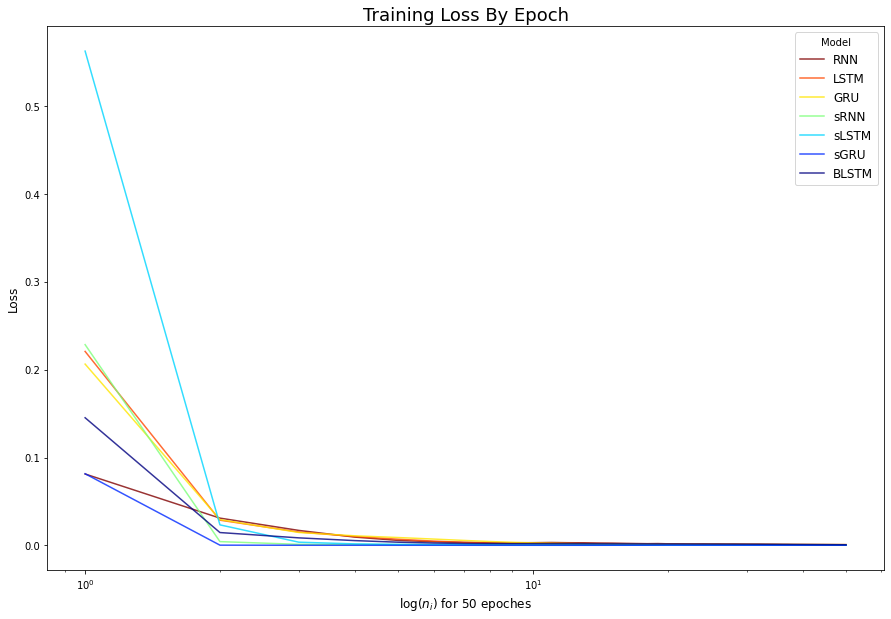

In [31]:
# Plot training loss by epoch
fig = plt.figure(figsize = (15, 10))
epoch_arr = np.arange(1, n_epoches + 1)
colors = pl.cm.jet(np.linspace(1, 0, 7))
i = 0

for k in params.keys():
    plt.plot(epoch_arr, params[k]['history'].history['loss'], color = colors[i], label = params[k]['label'], alpha = 0.8)
    i += 1
    
plt.xscale('log')
plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('$\log{(n_i)}$ for '  + str(n_epoches) + ' epoches', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.title('Training Loss By Epoch', fontsize = 18)

plt.show()

Text(0.5, 1.0, 'Near-term Forecasting Residual ($\\hat{Y_i} - Y_i$)')

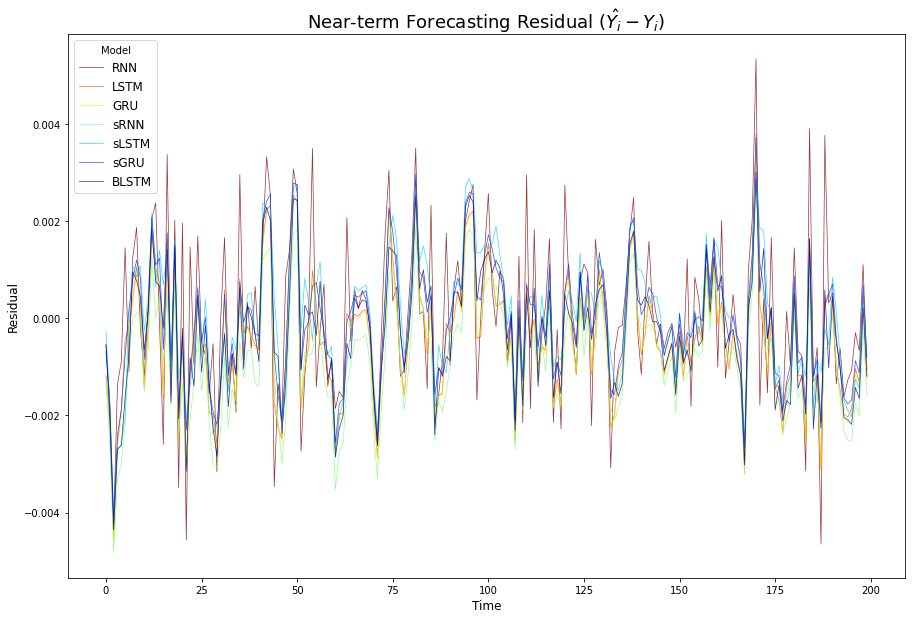

In [44]:
# Plot near_term forecasting residuals for test set
upper_limit = 200
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, upper_limit).reshape(upper_limit, 1)
colors = pl.cm.jet(np.linspace(1, 0, 7))
i = 0

for k in params.keys():
    residual = params[k]['predict'][:upper_limit] - y_test_reg[:upper_limit].reshape(upper_limit, 1)
    plt.plot(_x, residual, color = colors[i], label = params[k]['label'], alpha = 0.8, linewidth = 0.7)
    i += 1

plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('Near-term Forecasting Residual ($\hat{Y_i} - Y_i$)', fontsize = 18)

Text(0.5, 1.0, 'Trimmed Test Residual ($\\hat{Y_i} - Y_i$)')

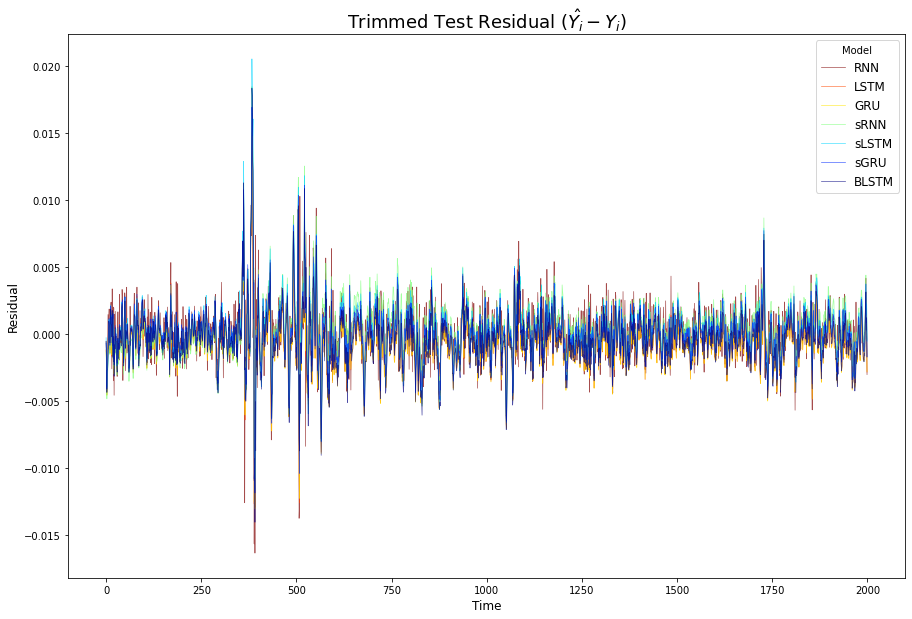

In [33]:
# Plot trimmed residuals for test set
upper_limit = 2000
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, upper_limit).reshape(upper_limit, 1)
colors = pl.cm.jet(np.linspace(1, 0, 7))
i = 0

for k in params.keys():
    residual = params[k]['predict'][:upper_limit] - y_test_reg[:upper_limit].reshape(upper_limit, 1)
    plt.plot(_x, residual, color = colors[i], label = params[k]['label'], alpha = 0.7, linewidth = 0.7)
    i += 1

plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('Trimmed Test Residual ($\hat{Y_i} - Y_i$)', fontsize = 18)

Text(0.5, 1.0, 'Untrimmed Test Residual ($\\hat{Y_i} - Y_i$)')

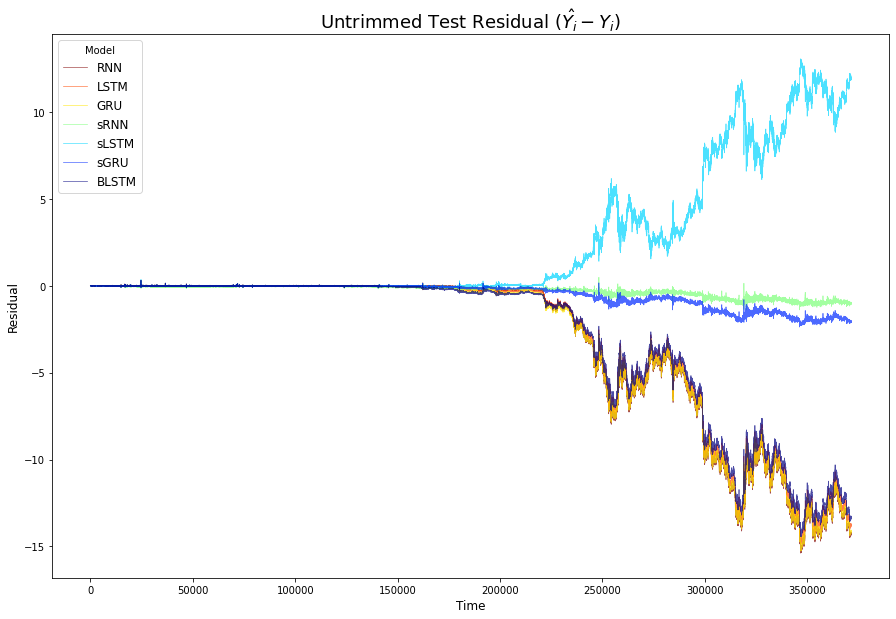

In [34]:
# Plot untrimmed residuals for test set
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, len(y_test_reg))
colors = pl.cm.jet(np.linspace(1, 0, 7))
i = 0

for k in params.keys():
    residual = params[k]['predict'] - y_test_reg
    plt.plot(_x, residual, color = colors[i], label = params[k]['label'], alpha = 0.7, linewidth = 0.7)
    i += 1

plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('Untrimmed Test Residual ($\hat{Y_i} - Y_i$)', fontsize = 18)

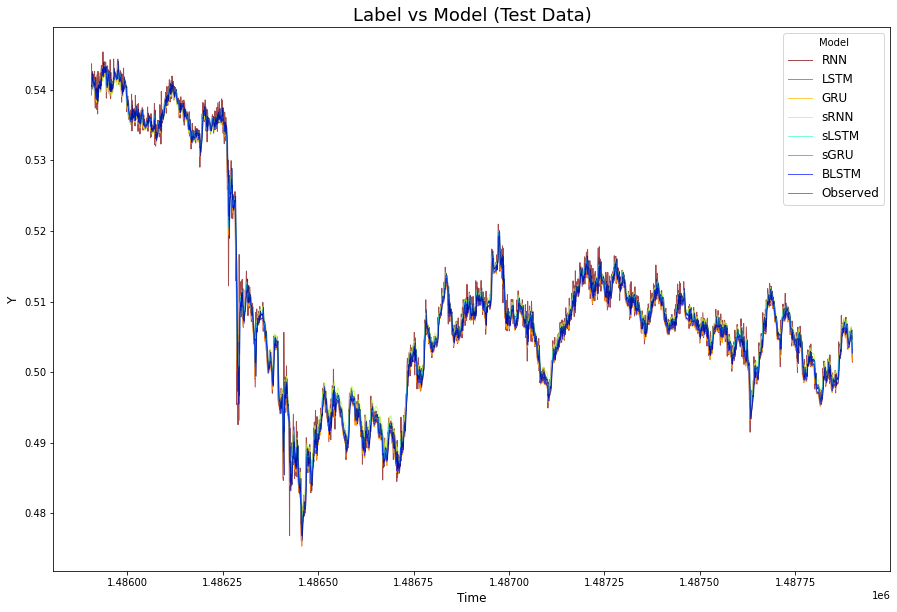

In [35]:
# Plot prediction vs label performance
fig = plt.figure(figsize = (15, 10))
upper_limit = 2000
colors = pl.cm.jet(np.linspace(1, 0, 8))
i = 0

for k in params.keys():
    plt.plot(test.index[step_lag : upper_limit], params[k]['predict'][step_lag : upper_limit], linewidth = 1.0,
             color = colors[i], label = params[k]['label'], alpha = 0.7)
    i += 1
    
plt.plot(test.index[step_lag : upper_limit], test[features][step_lag : upper_limit], linewidth = 0.7,
         color = colors[i], label = 'Observed', alpha = 0.7)

plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Label vs Model (Test Data)', fontsize = 18)

plt.show()

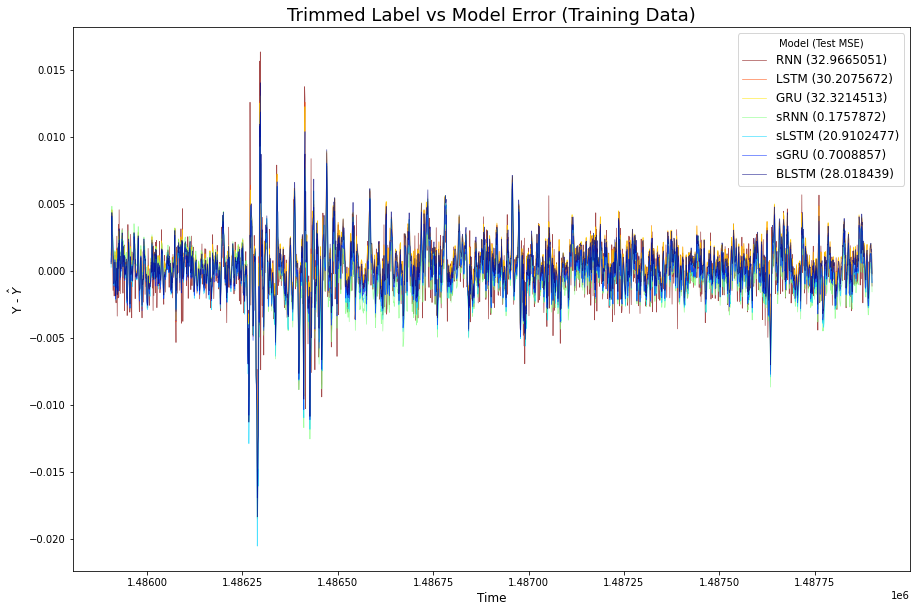

In [36]:
# Plot prediction vs label error
fig = plt.figure(figsize = (15, 10))
dim = len(test.index[step_lag : upper_limit])
x_plot = test.index[step_lag : upper_limit]
colors = pl.cm.jet(np.linspace(1, 0, 7))
i = 0

for k in params.keys():
    nn_y_plot = test[features][step_lag : upper_limit] - params[k]['predict'][: upper_limit - (step_lag), 0].reshape(dim, 1)
    plt.plot(x_plot, nn_y_plot, color = colors[i], label = params[k]['label'] + " (" + str( round( params[k]['MSE_test'], 7) ) + ")",
             alpha = 0.7, linewidth = 0.7)
    i += 1

plt.legend(loc = 'best', title = 'Model (Test MSE)', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Y - $\hat{Y}$', fontsize = 12)
plt.title('Trimmed Label vs Model Error (Training Data)', fontsize = 18)

plt.show()

In [37]:
print('Model Errors:')

for k in params.keys():
    print('Model: ' + params[k]['label'])
    print('   Train MSE = ' + str(params[k]['MSE_train']))
    print('   Test MSE = ' + str(params[k]['MSE_test']))
    print()

Model Errors:
Model: RNN
   Train MSE = 0.00030479414852807444
   Test MSE = 32.96650509729528

Model: LSTM
   Train MSE = 0.0037469139474643606
   Test MSE = 30.207567189890348

Model: GRU
   Train MSE = 0.0018162693962736612
   Test MSE = 32.321451268565966

Model: sRNN
   Train MSE = 0.0020183333301026355
   Test MSE = 0.1757872288316143

Model: sLSTM
   Train MSE = 0.0008530652183738926
   Test MSE = 20.91024770356743

Model: sGRU
   Train MSE = 0.0033823482138075254
   Test MSE = 0.700885722457028

Model: BLSTM
   Train MSE = 0.003394318888261103
   Test MSE = 28.018439041561695



In [41]:
print('Near-term Forecasting Error')
print()

for k in params.keys():
    print('Model: ' + params[k]['label'])
    temp = mean_squared_error(test[features][step_lag : 200], params[k]['predict'][step_lag : 200])
    print('   MSE = ' + str(temp))
    print()

Near-term Forecasting Error

Model: RNN
   MSE = 2.5323062218409135e-06

Model: LSTM
   MSE = 1.3998170062277204e-06

Model: GRU
   MSE = 1.339575661262674e-06

Model: sRNN
   MSE = 1.2372096415300602e-06

Model: sLSTM
   MSE = 2.7057301316284504e-07

Model: sGRU
   MSE = 8.241699848385835e-07

Model: BLSTM
   MSE = 4.664902755755654e-07



In [47]:
print('5-Fold GridCV Results')
print()

for k in params.keys():
    print('Model: ' + params[k]['label'])
    print(params[k]['cv_results'])

5-Fold GridCV Results

Model: RNN
{'mean_fit_time': array([2.79829745, 2.48722038, 2.01439757, 2.10075822, 2.09819636,
       2.04111953, 2.07969351, 2.03408346, 2.15985684, 2.12174482,
       2.28613424, 2.14594474]), 'std_fit_time': array([0.72853454, 0.51733887, 0.50855692, 0.42787324, 0.67246581,
       0.51761621, 0.66969885, 0.58182046, 0.68739935, 0.5396611 ,
       0.70609811, 0.66043257]), 'mean_score_time': array([0.16383305, 0.1591116 , 0.1366611 , 0.14082513, 0.13878407,
       0.14096465, 0.13937492, 0.13983459, 0.14141722, 0.14394574,
       0.14041648, 0.13965969]), 'std_score_time': array([0.0259458 , 0.0373406 , 0.00187541, 0.00320045, 0.00280444,
       0.00435024, 0.00160162, 0.00256009, 0.00356686, 0.00574116,
       0.00282278, 0.00250364]), 'param_l1_reg': masked_array(data=[1e-05, 1e-05, 1e-05, 5e-05, 5e-05, 5e-05, 0.0001,
                   0.0001, 0.0001, 0.001, 0.001, 0.001],
             mask=[False, False, False, False, False, False, False, False,
          